### Peforming checks for the resources available

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Installing huggingface transformers library

In [3]:
!pip install transformers

     |████████████████████████████████| 1.5MB 9.4MB/s 
     |████████████████████████████████| 890kB 28.5MB/s 
     |████████████████████████████████| 2.9MB 38.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=bdeb04ba453849fb3ac3b2b18be5c29cbce0dba211467a67118b6a25b10d994a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Importing drive into the colaboratory

In [4]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


### Importing dataset directories

In [5]:
from os import getcwd , listdir 
from os.path import join
curr_dir = getcwd()
drive_dir = join(curr_dir , 'drive','MyDrive')
dataset_dir = join(drive_dir,'Codalab','HopeSpeech Detection For Equality,DiversityAnd Inclusion','Dataset')

In [6]:
listdir(dataset_dir)

['english_hope_dev.csv',
 'english_hope_train.csv',
 'malayalam_hope_dev.csv',
 'malayalam_hope_train.csv',
 'tamil_hope_first_dev.csv',
 'tamil_hope_first_train.csv']

### Loading training data

In [7]:
import pandas as pd
import numpy as np 
import random

train_df_path = join(dataset_dir,'tamil_hope_first_train.csv')
# Load the dataset into a pandas dataframe.
df = pd.read_csv(train_df_path)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 16,160



,text,label
5513,Seems like end for world,Hope_speech
5629,கச்சா எண்ணெய் ஒரு பீப்பாய் பத்து டாலர் விர்க்க...,Hope_speech
328,1min 342 views,Non_hope_speech
7000,Yaru la tik tok kaga inoru app pakka vandhinga...,Hope_speech
3060,Tamilpokkisham mum parunga friends it’s good,Hope_speech
1507,Bro nega daily post Panna pothum🤘,Hope_speech
14095,Sivakasi child ah pathi pesunga bro,Non_hope_speech
1782,7.30 pm best time,Hope_speech
5657,3 files super,Hope_speech
1073,Oru Nala futurela India la mobile manufacturin...,Hope_speech


In [8]:
df['label'].value_counts()

Non_hope_speech    7872
Hope_speech        6327
not-Tamil          1961
Name: label, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [10]:
df['label'].value_counts()

1    7872
0    6327
2    1961
Name: label, dtype: int64

### Loading `train_sentences` and `train_labels`

In [11]:
# Get the lists of sentences and their labels.
train_sentences = df['text'].values
train_labels = df['label'].values

### Handling class imbalance using `sklearn's comput_class_weight`

In [12]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.85137769 0.68428184 2.74689784]


### Helper Functions

#### 1) Update Interval Function

In [13]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval 
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller. 
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

#### 2) Format time function

In [14]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


#### 3) Make Smart Batches function

In [15]:
def make_smart_batches(text_samples, labels, batch_size,tokenizer,max_input_length):
    '''
    This function combines all of the required steps to prepare batches.
    '''

    print('Creating Smart Batches from {:,} examples with batch size {:,}...\n'.format(len(text_samples), batch_size))

    # =========================
    #   Tokenize & Truncate
    # =========================

    full_input_ids = []

    # Tokenize all training examples
    print('Tokenizing {:,} samples...'.format(len(labels)))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(labels), num_desired_updates=10)

    # For each training example...
    for text in text_samples:
        
        # Report progress.
        if ((len(full_input_ids) % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

        # Tokenize the sample.
        input_ids = tokenizer.encode(text=text,              # Text to encode.
                                    add_special_tokens=True, # Do add specials.
                                    max_length=max_input_length,      
                                    truncation=True,         # Do Truncate!
                                    padding=False)           # DO NOT pad.
                                    
        # Add the tokenized result to our list.
        full_input_ids.append(input_ids)
        
    print('DONE.')
    print('{:>10,} samples\n'.format(len(full_input_ids)))

    # =========================
    #      Select Batches
    # =========================    

    # Sort the two lists together by the length of the input sequence.
    samples = sorted(zip(full_input_ids, labels), key=lambda x: len(x[0]))

    print('{:>10,} samples after sorting\n'.format(len(samples)))

    import random

    # List of batches that we'll construct.
    batch_ordered_sentences = []
    batch_ordered_labels = []

    print('Creating batches of size {:}...'.format(batch_size))

    # Choose an interval on which to print progress updates.
    update_interval = good_update_interval(total_iters=len(samples), num_desired_updates=10)
    
    # Loop over all of the input samples...    
    while len(samples) > 0:
        
        # Report progress.
        if ((len(batch_ordered_sentences) % update_interval) == 0 \
            and not len(batch_ordered_sentences) == 0):
            print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

        # `to_take` is our actual batch size. It will be `batch_size` until 
        # we get to the last batch, which may be smaller. 
        to_take = min(batch_size, len(samples))

        # Pick a random index in the list of remaining samples to start
        # our batch at.
        select = random.randint(0, len(samples) - to_take)

        # Select a contiguous batch of samples starting at `select`.
        #print("Selecting batch from {:} to {:}".format(select, select+to_take))
        batch = samples[select:(select + to_take)]

        #print("Batch length:", len(batch))

        # Each sample is a tuple--split them apart to create a separate list of 
        # sequences and a list of labels for this batch.
        batch_ordered_sentences.append([s[0] for s in batch])
        batch_ordered_labels.append([s[1] for s in batch])

        # Remove these samples from the list.
        del samples[select:select + to_take]

    print('\n  DONE - Selected {:,} batches.\n'.format(len(batch_ordered_sentences)))

    # =========================
    #        Add Padding
    # =========================    

    print('Padding out sequences within each batch...')

    py_inputs = []
    py_attn_masks = []
    py_labels = []

    # For each batch...
    for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

        # New version of the batch, this time with padded sequences and now with
        # attention masks defined.
        batch_padded_inputs = []
        batch_attn_masks = []
        
        # First, find the longest sample in the batch. 
        # Note that the sequences do currently include the special tokens!
        max_size = max([len(sen) for sen in batch_inputs])

        # For each input in this batch...
        for sen in batch_inputs:
            
            # How many pad tokens do we need to add?
            num_pads = max_size - len(sen)

            # Add `num_pads` padding tokens to the end of the sequence.
            padded_input = sen + [tokenizer.pad_token_id]*num_pads

            # Define the attention mask--it's just a `1` for every real token
            # and a `0` for every padding token.
            attn_mask = [1] * len(sen) + [0] * num_pads

            # Add the padded results to the batch.
            batch_padded_inputs.append(padded_input)
            batch_attn_masks.append(attn_mask)

        # Our batch has been padded, so we need to save this updated batch.
        # We also need the inputs to be PyTorch tensors, so we'll do that here.
        # Todo - Michael's code specified "dtype=torch.long"
        py_inputs.append(torch.tensor(batch_padded_inputs))
        py_attn_masks.append(torch.tensor(batch_attn_masks))
        py_labels.append(torch.tensor(batch_labels))
    
    print('  DONE.')

    # Return the smart-batched dataset!
    return (py_inputs, py_attn_masks, py_labels)


#### 4) Function for calculating accuracy per class

In [16]:
def accuracy_per_class(preds, labels , label_dict):
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict[label]}')
        print(f'Accuracy: {round(100*len(y_preds[y_preds==label])/len(y_true) , 2)}\n')

## Smart Batching of the training data

In [17]:
from transformers import AutoTokenizer

model_name = 'bert-base-multilingual-uncased'
# Load the BERT tokenizer.
print(f'Loading {model_name} tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

Loading bert-base-multilingual-uncased tokenizer...


In [18]:
lengths = []
for text in train_sentences:
  lengths.append(len(text))       

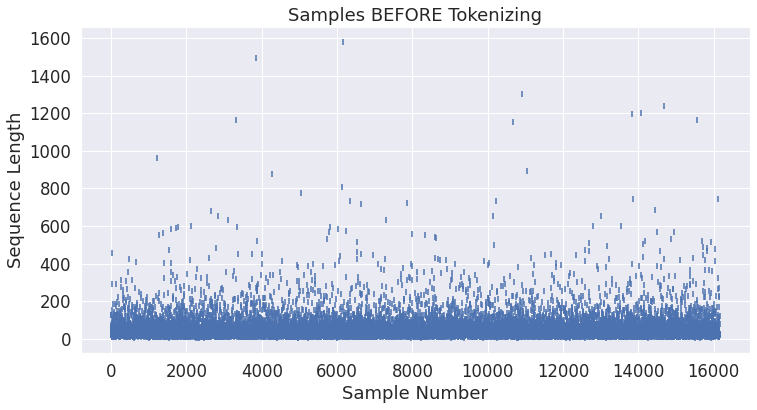

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(lengths)), lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Tokenizing')

plt.show()

### Tokenizing the sequences

In [20]:
max_input_length = 400

In [21]:
full_input_ids = []
labels = []

# Tokenize all training examples
print('Tokenizing {:,} training samples...'.format(len(train_sentences)))

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(train_sentences), num_desired_updates=10)

# For each training example...
for text in train_sentences:
    
    # Report progress.
    if ((len(full_input_ids) % update_interval) == 0):
        print('  Tokenized {:,} samples.'.format(len(full_input_ids)))

    # Tokenize the sentence.
    input_ids = tokenizer.encode(text=text,           
                                 add_special_tokens=True, 
                                 max_length=max_input_length,  
                                 truncation=True,     
                                 padding=False)       
                                 
    # Add the tokenized result to our list.
    full_input_ids.append(input_ids)
    
print('DONE.')
print('{:>10,} samples'.format(len(full_input_ids)))

Tokenizing 16,160 training samples...
  Tokenized 0 samples.
  Tokenized 2,000 samples.
  Tokenized 4,000 samples.
  Tokenized 6,000 samples.
  Tokenized 8,000 samples.
  Tokenized 10,000 samples.
  Tokenized 12,000 samples.
  Tokenized 14,000 samples.
  Tokenized 16,000 samples.
DONE.
    16,160 samples


In [22]:
# Get all of the lengths.
unsorted_lengths = [len(x) for x in full_input_ids]

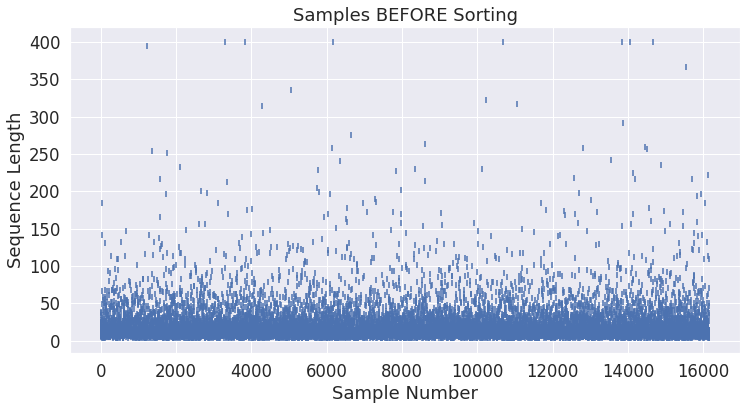

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.scatter(range(0, len(unsorted_lengths)), unsorted_lengths, marker="|")

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples BEFORE Sorting')

plt.show()

In [24]:
# Sort the two lists together by the length of the input sequence.
train_samples = sorted(zip(full_input_ids, train_labels), key=lambda x: len(x[0]))

In [25]:
train_samples[0:5]

[([101, 23336, 102], 0),
 ([101, 10763, 102], 2),
 ([101, 137, 102], 2),
 ([101, 18437, 23336, 102], 2),
 ([101, 18437, 23336, 102], 2)]

In [26]:
print('Shortest sample:', len(train_samples[0][0]))
print('Longest sample:', len(train_samples[-1][0]))

Shortest sample: 3
Longest sample: 400


In [27]:
# Get the new list of lengths after sorting.
sorted_lengths = [len(s[0]) for s in train_samples]

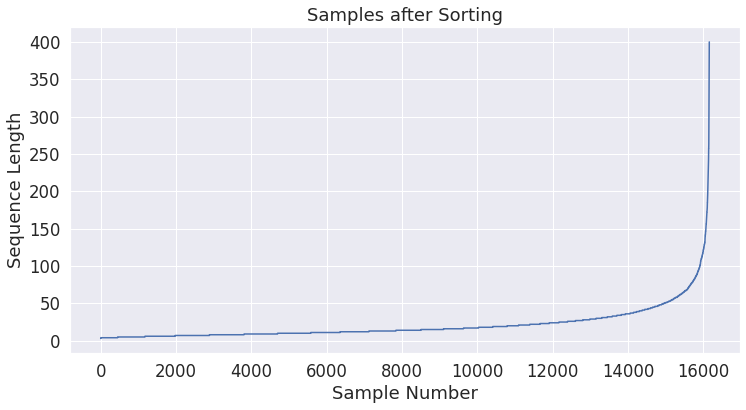

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

plt.xlabel('Sample Number')
plt.ylabel('Sequence Length')
plt.title('Samples after Sorting')

plt.show()

### Random Batch Selections

In [29]:
train_samples[0]

([101, 23336, 102], 0)

In [30]:
batch_size = 16

In [31]:
import random

# List of batches that we'll construct.
batch_ordered_sentences = []
batch_ordered_labels = []

print('Creating training batches of size {:}'.format(batch_size))

# Loop over all of the input samples...    
while len(train_samples) > 0:
    
    # Report progress.
    if ((len(batch_ordered_sentences) % 100) == 0):
        print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

    # `to_take` is our actual batch size. It will be `batch_size` until 
    # we get to the last batch, which may be smaller. 
    to_take = min(batch_size, len(train_samples))

    # Pick a random index in the list of remaining samples to start
    # our batch at.
    select = random.randint(0, len(train_samples) - to_take)

    # Select a contiguous batch of samples starting at `select`.
    batch = train_samples[select:(select + to_take)]

    # Each sample is a tuple--split them apart to create a separate list of 
    # sequences and a list of labels for this batch.
    batch_ordered_sentences.append([s[0] for s in batch])
    batch_ordered_labels.append([s[1] for s in batch])

    # Remove these samples from the list.
    del train_samples[select:select + to_take]

print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))

Creating training batches of size 16
  Selected 0 batches.
  Selected 100 batches.
  Selected 200 batches.
  Selected 300 batches.
  Selected 400 batches.
  Selected 500 batches.
  Selected 600 batches.
  Selected 700 batches.
  Selected 800 batches.
  Selected 900 batches.
  Selected 1,000 batches.

  DONE - 1,010 batches.


In [32]:
print(batch_ordered_sentences[0])

[[101, 17140, 13054, 11379, 102], [101, 11463, 34307, 15584, 102], [101, 20220, 10935, 48458, 102], [101, 32738, 10114, 10525, 102], [101, 127, 27875, 26895, 102], [101, 12487, 12319, 26895, 102], [101, 12200, 29263, 11531, 102], [101, 23293, 16925, 26895, 102], [101, 17140, 13054, 18491, 102], [101, 23293, 16925, 26895, 102], [101, 11737, 10127, 12888, 102], [101, 22297, 14666, 37959, 102], [101, 26895, 29155, 35821, 102], [101, 67715, 10855, 12301, 102], [101, 42946, 10195, 19649, 102], [101, 12225, 25129, 13670, 102]]


In [33]:
batch_ordered_labels[0]

[0, 2, 1, 1, 2, 2, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2]

### Padding

In [34]:
import torch

py_inputs = []
py_attn_masks = []
py_labels = []

# For each batch...
for (batch_inputs, batch_labels) in zip(batch_ordered_sentences, batch_ordered_labels):

    # New version of the batch, this time with padded sequences and now with
    # attention masks defined.
    batch_padded_inputs = []
    batch_attn_masks = []
    
    # First, find the longest sample in the batch. 
    # Note that the sequences do currently include the special tokens!
    max_size = max([len(sen) for sen in batch_inputs])

    #print('Max size:', max_size)

    # For each input in this batch...
    for sen in batch_inputs:
        
        # How many pad tokens do we need to add?
        num_pads = max_size - len(sen)

        # Add `num_pads` padding tokens to the end of the sequence.
        padded_input = sen + [tokenizer.pad_token_id]*num_pads

        # Define the attention mask--it's just a `1` for every real token
        # and a `0` for every padding token.
        attn_mask = [1] * len(sen) + [0] * num_pads

        # Add the padded results to the batch.
        batch_padded_inputs.append(padded_input)
        batch_attn_masks.append(attn_mask)

    # Our batch has been padded, so we need to save this updated batch.
    # We also need the inputs to be PyTorch tensors, so we'll do that here.
    py_inputs.append(torch.tensor(batch_padded_inputs))
    py_attn_masks.append(torch.tensor(batch_attn_masks))
    py_labels.append(torch.tensor(batch_labels))


### Check the number of token reductions because of smart batching

In [35]:
# Get the new list of lengths after sorting.
import numpy as np
padded_lengths = []

# For each batch...
for batch in py_inputs:
    
    # For each sample...
    for s in batch:
    
        # Record its length.
        padded_lengths.append(len(s))

# Sum up the lengths to the get the total number of tokens after smart batching.
smart_token_count = np.sum(padded_lengths)

# To get the total number of tokens in the dataset using fixed padding, it's
# as simple as the number of samples times our `max_len` parameter (that we
# would pad everything to).
fixed_token_count = len(train_sentences) * max_input_length

# Calculate the percentage reduction.
prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

print('Total tokens:')
print('   Fixed Padding: {:,}'.format(fixed_token_count))
print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))


Total tokens:
   Fixed Padding: 6,464,000
  Smart Batching: 358,848  (94.4% less)


## Load the model configuration from the transformers library using AutoConfig

In [36]:
from transformers import AutoConfig

# Load the Config object, with an output configured for classification.
config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name,
                                    num_labels=3)

print('Config type:', str(type(config)), '\n')


Config type: <class 'transformers.models.bert.configuration_bert.BertConfig'> 



In [37]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name,config = config)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [38]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

## Load the model from the transformers library using AutoModel

In [39]:
from transformers import AutoModel

# Load the pre-trained model for classification, passing in the `config` from
# above.
bert = AutoModel.from_pretrained(
    pretrained_model_name_or_path=model_name,
    config=config)

print('\nModel type:', str(type(bert)))



Model type: <class 'transformers.models.bert.modeling_bert.BertModel'>


In [40]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

## Creating a custom BERT model 

In [ ]:
import torch.nn as nn
class BERT_Model(nn.Module):
    ## defining the constructor for the class
    def __init__(self, bert,num_labels):
      ## calling the super class constructor
      super(BERT_Model, self).__init__()
      ## adding the bert layer to the model
      self.bert = bert        
      # relu activation function
      self.relu =  nn.ReLU()
      # adding a dense layer to our custom model
      self.fc1 = nn.Linear(768,512)
      # adding another dense layer to our custom model ,i.e., the Output layer
      self.fc2 = nn.Linear(512,num_labels)
      # adding a softmax  activation function for our custom model's output layer
      self.softmax = nn.LogSoftmax(dim=1)

    #defining the forward pass
    def forward(self, input_id, mask):
      #pass the inputs to the model  
      outputs = self.bert(input_id,mask)
  
      last_hidden_state = outputs.last_hidden_state       ## last hidden state from the model
      pooler_output = outputs.pooler_output               ## pooler output from the model
      ## adding a fully connected layer to the BERT model
      x = self.fc1(pooler_output)
      ## applying relu activation function
      x = self.relu(x)
      # the final output layer
      x = self.fc2(x)
      # apply softmax activation to our output layer
      x = self.softmax(x)

      return x

In [ ]:
import torch

print('\nLoading model ...')
# pass the pre-trained BERT to our define architecture
model = BERT_Model(bert,num_labels=3)

model.cuda()


Loading model ...


BERT_Model(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)


## Custom Loss function

In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 


## Loading Optimizer

In [41]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # This is the value Michael used.
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


## Loading lr scheduler

In [42]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. I chose to train for 1 simply because the training
# time is long. More epochs may improve the model's accuracy.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# Note that it's the number of *batches*, not *samples*!
total_steps = len(py_inputs) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [43]:
import random
import numpy as np
import time

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Update every `update_interval` batches.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    # At the start of each epoch (except for the first) we need to re-randomize
    # our training data.
    if epoch_i > 0:
        # Use our `make_smart_batches` function (from 6.1.) to re-shuffle the 
        # dataset into new batches.
        (py_inputs, py_attn_masks, py_labels) = make_smart_batches(train_sentences, train_labels, batch_size,tokenizer,max_input_length)
    
    print('Training on {:,} batches...'.format(len(py_inputs)))

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step in range(0, len(py_inputs)):

        # Progress update every, e.g., 100 batches.
        if step % update_interval == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Calculate the time remaining based on our progress.
            steps_per_sec = (time.time() - t0) / step
            remaining_sec = steps_per_sec * (len(py_inputs) - step)
            remaining = format_time(remaining_sec)

            # Report progress.
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

        # Copy the current training batch to the GPU using the `to` method.
        b_input_ids = py_inputs[step].to(device)
        b_input_mask = py_attn_masks[step].to(device)
        b_labels = py_labels[step].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The call returns the loss (because we provided labels) and the 
        # "logits"--the model outputs prior to activation.
        output = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = output.loss 
        logits = output.logits
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(py_inputs)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training on 1,010 batches...
  Batch     100  of    1,010.    Elapsed: 0:00:13.  Remaining: 0:01:54
  Batch     200  of    1,010.    Elapsed: 0:00:26.  Remaining: 0:01:46
  Batch     300  of    1,010.    Elapsed: 0:00:40.  Remaining: 0:01:34
  Batch     400  of    1,010.    Elapsed: 0:00:52.  Remaining: 0:01:19
  Batch     500  of    1,010.    Elapsed: 0:01:05.  Remaining: 0:01:06
  Batch     600  of    1,010.    Elapsed: 0:01:19.  Remaining: 0:00:54
  Batch     700  of    1,010.    Elapsed: 0:01:33.  Remaining: 0:00:41
  Batch     800  of    1,010.    Elapsed: 0:01:46.  Remaining: 0:00:28
  Batch     900  of    1,010.    Elapsed: 0:02:00.  Remaining: 0:00:15
  Batch   1,000  of    1,010.    Elapsed: 0:02:14.  Remaining: 0:00:01

  Average training loss: 0.79
  Training epoch took: 0:02:16

======== Epoch 2 / 4 ========
Creating Smart Batches from 16,160 examples with batch size 16...

Tokenizing 16,160 samples...
  Tokenized 0 samples.
  Tokenized 2,000 

## Loading the validation data

In [44]:
val_df_path = join(dataset_dir,'tamil_hope_first_dev.csv')
# Load the dataset into a pandas dataframe.
df = pd.read_csv(val_df_path)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 2,018



,text,label
1556,9.00 pm kulla podunga brother,Hope_speech
526,Ayya ippa irnthiruntha avaroda anugundaiyae po...,Non_hope_speech
393,Subscribe sollitu kannulai kaiya vaichi kuthth...,Non_hope_speech
1789,Pompéo will be like,Hope_speech
433,Plasma explain pannu Anna plz..,Non_hope_speech
1159,இது எத்தனாவது ஆப்போ....?,Non_hope_speech
1090,China Xi Jinping,Non_hope_speech
429,நண்பா நீஙக 'Hello everyone'ன்னு சொல்லுக்கு பதி...,Non_hope_speech
1802,Bro be safe,Hope_speech
530,bro aana yenga v2la panni irukee,Non_hope_speech


## Loading `test_sentences` and `test_labels`

In [45]:
df['label'] = le.transform(df['label'])

In [46]:
test_sentences = df['text'].values 
test_labels = df['label'].values

In [47]:
# Use our new function to completely prepare our dataset.
(py_inputs, py_attn_masks, py_labels) = make_smart_batches(test_sentences, test_labels, batch_size ,tokenizer,max_input_length)

Creating Smart Batches from 2,018 examples with batch size 16...

Tokenizing 2,018 samples...
  Tokenized 0 samples.
  Tokenized 200 samples.
  Tokenized 400 samples.
  Tokenized 600 samples.
  Tokenized 800 samples.
  Tokenized 1,000 samples.
  Tokenized 1,200 samples.
  Tokenized 1,400 samples.
  Tokenized 1,600 samples.
  Tokenized 1,800 samples.
  Tokenized 2,000 samples.
DONE.
     2,018 samples

     2,018 samples after sorting

Creating batches of size 16...

  DONE - Selected 127 batches.

Padding out sequences within each batch...
  DONE.


## Making predictions on our test dataset

In [49]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_labels)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Choose an interval on which to print progress updates.
update_interval = good_update_interval(total_iters=len(py_inputs), num_desired_updates=10)

# Measure elapsed time.
t0 = time.time()

# Put model in evaluation mode
model.eval()

# For each batch of training data...
for step in range(0, len(py_inputs)):

    # Progress update every 100 batches.
    if step % update_interval == 0 and not step == 0:
        # Calculate elapsed time in minutes.
        elapsed = format_time(time.time() - t0)
        
        # Calculate the time remaining based on our progress.
        steps_per_sec = (time.time() - t0) / step
        remaining_sec = steps_per_sec * (len(py_inputs) - step)
        remaining = format_time(remaining_sec)

        # Report progress.
        print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}.  Remaining: {:}'.format(step, len(py_inputs), elapsed, remaining))

    # Copy the batch to the GPU.
    b_input_ids = py_inputs[step].to(device)
    b_input_mask = py_attn_masks[step].to(device)
    b_labels = py_labels[step].to(device)
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, b_input_mask)

    logits = outputs.logits 

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,018 test sentences...
  Batch      10  of      127.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch      20  of      127.    Elapsed: 0:00:00.  Remaining: 0:00:02
  Batch      30  of      127.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      40  of      127.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      50  of      127.    Elapsed: 0:00:01.  Remaining: 0:00:02
  Batch      60  of      127.    Elapsed: 0:00:01.  Remaining: 0:00:01
  Batch      70  of      127.    Elapsed: 0:00:02.  Remaining: 0:00:01
  Batch      80  of      127.    Elapsed: 0:00:02.  Remaining: 0:00:01
  Batch      90  of      127.    Elapsed: 0:00:02.  Remaining: 0:00:01
  Batch     100  of      127.    Elapsed: 0:00:02.  Remaining: 0:00:01
  Batch     110  of      127.    Elapsed: 0:00:03.  Remaining: 0:00:00
  Batch     120  of      127.    Elapsed: 0:00:03.  Remaining: 0:00:00
    DONE.


## Evaluating accuracy over test set

In [50]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Choose the label with the highest score as our prediction.
preds = np.argmax(predictions, axis=1).flatten()

# Calculate simple flat accuracy -- number correct over total number.
accuracy = (preds == true_labels).mean()

print('Accuracy: {:.3f}'.format(accuracy))

Accuracy: 0.630


## Classification report of our predictions

In [51]:
class_names = ['Hope_speech' , 'Non-hope-speech'  , 'not-Tamil']

In [52]:
from sklearn.metrics import classification_report
print(classification_report(preds,true_labels , target_names=class_names))

                 precision    recall  f1-score   support

    Hope_speech       0.51      0.58      0.54       657
Non-hope-speech       0.70      0.66      0.68      1058
      not-Tamil       0.72      0.63      0.67       303

       accuracy                           0.63      2018
      macro avg       0.64      0.62      0.63      2018
   weighted avg       0.64      0.63      0.63      2018



In [53]:
label_dict = { 0:'Hope_speech' , 1:'Non-hope-speech'  , 2:'not-Tamil'}

In [54]:
accuracy_per_class(predictions, true_labels , label_dict)

Class: Hope_speech
Accuracy: 50.59

Class: Non-hope-speech
Accuracy: 69.94

Class: not-Tamil
Accuracy: 72.24



## Saving the model

In [55]:
torch.save(model,"./drive/MyDrive/Codalab/HopeSpeech Detection For Equality,DiversityAnd Inclusion/Models/BERTForSequenceClassification_Multilingual_Tamil_")